# Linear regression with Python: a short tutorial
**Written by : Faiz Izzatturahman, Mohammad Daffa Robani**

**Edited and maintained by: Pramudita Satria Palar, Javensius Sembiring, Edy Suwondo, Khairul Ummah, Yohanes Bimo Dwianto.**

**Last updated: 18-April-2023**

This Python notebook explains a multiple linear regression model applied to a simple two-variable problem. 

There are several existing packages for linear regression (e.g. ```sklearn```) that you can use easily. However, in this notebook, we coded linear regression from scratch (which is not difficult anyway), so you can see the translation of what you just learned from class into Python codes. 

At the end of the notebook, we will also use KNN-regression from ```sklearn``` so that you can directly try and compare the approximation capability of a non-parametric model (i.e., KNN-regression) and parametric model (i.e., linear regression). ```sklearn``` is used because it is one of the most popular machine learning packages.

The very first step is to import several packages that we will use, to be more specific:
- ```numpy``` for supporting multi-dimensional matrices.
- ```pandas``` for importing the CSV data (although ```pandas``` has more capabilities!)
- ```scipy```, specifically we will use the statistic package from scipy.
- ```matplotlib``` for plotting the data.
- ```mpl_toolkits``` for 3D plotting.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats import weightstats as stests
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 13})
from mpl_toolkits.mplot3d import Axes3D
import io

# Importing and Organizing The Data + Preliminary analysis




The first step you need to do is upload the data into your local cloud folder. To that end, we will use ```drive.mount()``` from ```google.colab```. For this tutorial, we will use the ```Advertising_2D.csv```. However, you can actually use any CSV data! The first columns of your CSV should consist of the matrix of observation (your data set $\boldsymbol{X}$): 

$\boldsymbol{X} = \begin{bmatrix} x_{11} & x_{12} & \ldots & x_{1p}\\
x_{21} & x_{22} & \ldots & x_{2p} \\
\vdots & \vdots & \vdots & \vdots \\
 x_{n1} & x_{n2} & \ldots & x_{np}\end{bmatrix}$

where $n$ is the number of samples and $p$ is the number of input variables / features. The last column of your CSV should consist of the output $\boldsymbol{y}$:

$\boldsymbol{y} = ( y_{1},y_{2},\ldots,y_{n})^{T}$

However, usually, we use the first column to indicate the number of observations. Hence, we use this format for this notebook.

Let's execute the following cell to mount your Google Drive folder:


In [2]:
#from google.colab import files
#Import the data (in .csv file)
#uploaded = files.upload()

# from google.colab import drive
# drive.mount('/content/gdrive')

The ```Advertising_2D.csv``` data is in CSV (comma separated values) format so we need to transform the data into a form that is suitable for our linear regression model. We will utilize ```read.csv``` from the ```pandas``` module to do just that and read the data as ```data```. Afterwards, we will transfrom the data into a Numpy array by using ```data.to_numpy``` with name ```data_array```.

If you want to check the size of your data set, you can use ```data_array.shape[0]``` for the number of samples and ```data_array.shape[1]``` for the number of variables / feature / predictor in the data (essentially, the dimensionality of your input variables).

How does your data looks like? You can take the five first rows of the data by taking a slice of your data set: use ```data_array[:5]```.

In [3]:
#Read the .csv file using Panda's module
data = pd.read_csv('data/Advertising_2D.csv',index_col='Unnamed: 0') # You need to change this if the name of your csv file changes (the first column is the number of observation and we skip that)
#data = pd.read_csv('gdrive/My Drive/Colab Notebooks/AE2204 SDS - old/data/Advertising_2D.csv',index_col='Unnamed: 0') # You need to change this if the name of your csv file changes (the first column is the number of observation and we skip that)

#Convert the format of the data into numpy array. This procedure is conducted to make it consistent with other variables afterward. This formatted data will be saved as data_array.
data_array = data.to_numpy() # Convert the data into numpy format
n_entries = data_array.shape[0] #Count the number of data entries (number of samples)
n_var = data_array.shape[1]-1 #Count the number of variables in the data (feature/predictor)
print("Five first rows of the data: ")
print(data_array[:5])
print(data_array.shape)

Five first rows of the data: 
[[230.1  37.8  22.1]
 [ 44.5  39.3  10.4]
 [ 17.2  45.9   9.3]
 [151.5  41.3  18.5]
 [180.8  10.8  12.9]]
(200, 3)


To process the data, we need to separate $\boldsymbol{X}$ and $\boldsymbol{y}$ from the data (i.e., the sampling points and the responses, respectively). Let us do just that and print the five first rows of $\boldsymbol{X}$ and $\boldsymbol{y}$.

In [4]:
# # Extracting X and y. There are two ways you can do this, choose the one that you see fit

# # Method 1: Slicing the numpy data_array (We use this data if we know that y is placed as the last column of the data)
X = data_array[:,0:-1]  # Take X (features) from the data
y = data_array[:,-1].reshape(-1,1) #Take y (responses) from the data

# # Method 2: Handle data with pandas (DataFrame), then convert to numpy array
# print(data.head()) # This command will print out all the columns (and a few rows) of your imported data if you want to see the names of the headers.
# # Say my data has the headers 'A', 'B', 'C', 'D'. Where column 'C' is the output (y) and columns 'A', 'B' and 'D' are the inputs (X)
# X = data[['A', 'B', 'D']] # i run this to 'filter' the data to give me only the rows from 'A', 'B' and 'D' , Note the double square brackets [[...]]
# X = X.to_numpy() # We convert the DataFrame into a numpy array in order to perform matrix/arithmetic operations 
# y = data[['C']].to_numpy() # We can do this all in one line.

print("Five first rows of X: ")
print(X[:5])
print("Five first rows of y: ")
print(y[:5].reshape(-1,1)) # Reshape into a two-dimensional array

Five first rows of X: 
[[230.1  37.8]
 [ 44.5  39.3]
 [ 17.2  45.9]
 [151.5  41.3]
 [180.8  10.8]]
Five first rows of y: 
[[22.1]
 [10.4]
 [ 9.3]
 [18.5]
 [12.9]]


# **Pearson Correlation Coefficient (r)**
One useful technique to check the correlation between variables is to use Pearson correlation coefficient. You have learned the basic from class, so you know that positive $r$ means that both variables change in the same direction (and the opposite for negative $r$). Here is the equation for your reminder.

$r = \frac{\sum{(X_1 - \mu_{X_1})(X_2 - \mu_{X_2})}}{\sqrt{\sum{(X_1 - \mu_{X_1})^2}\sum{(X_2 - \mu_{X_2})^2}}}$

The Pearson Correlation Coefficient calculates the linear relationship between two datasets $X_1$ and $X_2$ with their respective mean values $\mu_{X_1}$ and $\mu_{X_2}$ . The coefficient, **r**, takes on values between -1 and +1. Whereby the sign of the value indicates negative or positive correlation. Finally, the magnitude determines how linear the correlation is. 

We will make a correlation matrix because you have two inputs and one output variables. For that, we will call ```stats.pearsonr``` to calculate the correlation


In [5]:
#Function to create correlation matrix from each variable in the data (using stats)
def correlmat(data):
    n_var = data.shape[1]-1
    correl = np.zeros((n_var+1,n_var+1))
    for i in range(n_var+1):
        for j in range(n_var+1):
            correl[i,j],_ = stats.pearsonr(data[:,i],data[:,j]) #Calculate pearson correlation coefficient
    return correl

Alternatively, we can directly code the Pearson's correlation coefficient without using any package; that's pretty easy, see below (you can run this one or the previous one, the result would be the same):

In [6]:
#Function to create correlation matrix from each variable in the data (by coding)
def correlmat(data):
    n_var = data.shape[1]-1
    correl = np.zeros((n_var+1,n_var+1))
    for i in range(n_var+1):
        for j in range(n_var+1):
            mu_i = np.mean(data[:,i])
            mu_j = np.mean(data[:,j])
            num = np.sum(np.multiply(data[:,i]-mu_i,data[:,j]-mu_j))
            den = np.sqrt(np.sum((data[:,i]-mu_i)**2)*np.sum((data[:,j]-mu_j)**2))
            correl[i,j] = num/den #Calculate pearson correlation coefficient
    return correl

Now that we have the ```correlmat``` function, all you need to do is to apply this function to your data set and print the result:

In [7]:
#To obtain the correlation matrix of the data, call correlmat function, input: data_array 
correl_matrix = correlmat(data_array) #The correlation matrix is saved as correl_matrix
print("Correlation Matrix: ")
print(correl_matrix)

Correlation Matrix: 
[[1.         0.05480866 0.78222442]
 [0.05480866 1.         0.57622257]
 [0.78222442 0.57622257 1.        ]]


In [8]:
data.corr()

,TV,radio,sales
TV,1.000000,0.054809,0.782224
radio,0.054809,1.000000,0.576223
sales,0.782224,0.576223,1.000000


Now, how would you interpret the correlation matrix that you just calculated?

# Visualizing your data set.
If your variable only has one or two variables, you can plot the data by using scatterplot. Let's use ```plt.scatter``` to do just that. Please run the cell below first:

In [9]:
#@title Visualize the data with scatter plot
#This procedure can only be conducted if the number of variables are 1/2
#Function to create scatter plot of the data
def datascatterplot(X,y):
  n_var = X.shape[1]
  if n_var == 1: #Procedure for one variable
      fig = plt.figure(figsize=[8,6])
      plt.scatter(X,y,color='tab:orange')
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.xlabel('x',fontsize=14)
      plt.ylabel('y',fontsize=14)
      plt.grid()
      plt.show()
  elif n_var == 2: #Procedure for two variables
      fig = plt.figure(figsize=[8,6])
      ax = plt.axes(projection='3d')
      ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange')
      ax.set_xlabel('x1',fontsize=14)
      ax.xaxis.labelpad = 10
      ax.set_ylabel('x2',fontsize=14)
      ax.yaxis.labelpad = 10
      ax.set_zlabel('y',fontsize=14)
      plt.title('Scatter Plot of the Samples',fontsize=16)
      plt.show()
  else:
      print("Your data has more than two variables")

Afterward, run the following cell to create a scatter plot of $\boldsymbol{x}_{1}$, $\boldsymbol{x}_{2}$ and $y$. You can see qualitatively how the input variables are related to the output. Although it looks nice, we want to do such an analysis in a quantitative manner; which is the reason why we need **multiple linear regression** model. Linear regression model allows us to infer the linear relationship between the input and the output. As we will see later, analyzing the coefficients gives us important insight into the problem!

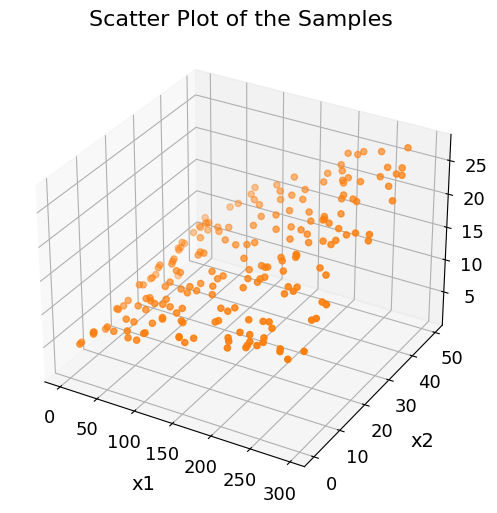

In [10]:
#To visualize the data, call datascatterplot function, input: X,y
datascatterplot(X,y)

# Creating a Linear Regression Model




**Linear Regression**

---
Given a dataset $X = (x_1, x_2, x_3, \dots , x_n)$, we can infer a *linear* function $\hat{f}$ such that it can provide us predictions $\hat{Y}$ at any given value of $x$. There are various approximation models, but we will limit our discussion to the simplest but highly useful one, i.e., linear regression. To do so, we use the linear regression equation,
\begin{equation}
Y = \beta_0 + \sum_{i=1}^{p} \beta_p X_{p} + \epsilon
\end{equation}
Where, $\beta_0$ is the intercept/bias and $\beta_i$ is the coefficient representing the slope of $f$ for the $i$-th variable (think of $m$ in $f(x)=mx+c$ for a 1-D line), and $\epsilon$ is the error. Our task is to estimate $\beta_{0},\beta_{2},\ldots,\beta_{p}$; thus, we have

\begin{equation}
\hat{y} = \hat{\beta_0} + \sum_{i=1}^{p} \hat{\beta_p} X_{p}
\end{equation}

in which we obtain $\hat{\beta_{0}}, \hat{\beta_{1}},\ldots, \hat{\beta_{p}}$ based on our data $\boldsymbol{X}$. It is easier to write the coefficients in a single vector, that is, $\boldsymbol{\beta} = \{\beta_{0},\beta_{1},\ldots,\beta_{p}\}$. To make the linear regression equation more compact, notice how the summation can be turned into a matrix dot product. To do this we simply *concatenate* a vector of ones into the data set $\boldsymbol{X}$ (lets call the resulting matrix as $\mathbf{F} = (\boldsymbol{1}, \boldsymbol{X})$. That is,
\begin{equation}
\mathbf{F}\boldsymbol{\beta} = \mathbf{y}
\end{equation}
The objective now is how do we calculate the unknown coefficients in the vector $\boldsymbol{\beta}$. Because there is no exact solution, we want to find the estimation $\hat{\boldsymbol{\beta}}$ that best fits the equation.

The linear regression equation defined above is a template for our **linear model**, meaning it is a model once we define the coefficient vector $\hat{\beta}$. The process of finding $\hat{\beta}$ is termed *fitting the (linear) model*. There are many methods of fitting the model, a common method is the method of *least squares*. This method chooses the coefficients for $\hat{\boldsymbol{\beta}}$ such that it minimizes the residual sum of squares (RSS). Why do we need to minimize RSS? In essence, we minimize RSS because we want our linear "line" (notice that I use "line" because it is a plane if we have more than one variable!)

The RSS is defined as,
\begin{equation}
RSS(\hat{\boldsymbol{\beta}}) = \sum_{i=1}^{n} (y_i-\hat{y}_{i})^2 = \sum_{i=1}^{n}(y_{i}-\hat{\beta}_{0}-\hat{\beta}_{1}x_{i1}-\hat{\beta}_{2}x_{i2}-\ldots-\hat{\beta}_{p}x_{ip})^{2}
\end{equation}
The equation above means that we want to reduce the sum of the squared error between the prediction and the data for all $n$ samples. We can write the equation above in terms of $\mathbf{y}$, $\mathbf{F}$, and $\boldsymbol{\beta}$

\begin{equation}
RSS(\hat{\boldsymbol{\beta}}) = (\mathbf{y}-\mathbf{F}\hat{\boldsymbol{\beta}})^T(\mathbf{y}-\mathbf{F}\hat{\boldsymbol{\beta}})
\end{equation}

To which the minimum can be found by differentiating w.r.t to $\hat{\beta}$ and rearranged to,
\begin{equation}
\hat{\boldsymbol{\beta}} = (\mathbf{F}^T\mathbf{F})^{-1}\mathbf{F}^T\mathbf{y}
\end{equation}

**Estimation of variance**

---
To estimate the variance, $\hat{\sigma}^2$, of the model, we use the RSS value as follows,

\begin{equation}
\hat{\sigma}^2 = \frac{RSS(\hat{\beta})}{n_{entries}-n_{variables}}
\end{equation}
Where $n_{entries}$ is the number of rows and $n_{variables}$ is the number of columns of $F$.
Thus, the variance of each coefficient in $\hat{\beta}$ would be the **diagonal elements** of,
\begin{equation}
Var(\hat{\beta}) = (\mathbf{F}^T\mathbf{F})^{-1}\hat{\sigma}^2
\end{equation}

The cell below creates the ```LinearRegression``` subroutine that you will need for calculation. The input to  ```LinearRegression``` is your data set $\boldsymbol{X}$ and the vector of output $\boldsymbol{y}$. For now, you can just execute the cell below to define the linear regression program. However, if you are curious on how to code linear regression, just read the code line by line and try to understand them!




In [11]:
#Function to train a linear regression model on the data. This function will provede regression coefficeints (beta) and its variances (beta_var).
def LinearRegression(X,y):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X 

    #Procedure to obtain regression coefficients by minimizing RSS error
    beta = np.linalg.inv(np.transpose(F)@F)@np.transpose(F)@y #Procedure to minimize RSS error
    #Procedure to obtain variances from the regression coefficients
    y_hat = F@beta #Predictions at X
    res_sqr = np.power((y-y_hat),2) #Calculate RSS of the trained linear regression model
    sig_hat_sqr = np.sum(res_sqr)/(n_entries-n_var-1) #Estimate sigma squared
    beta_var = (np.linalg.inv(np.transpose(F)@F)*sig_hat_sqr).diagonal() #Calculate variance of each regression coefficient
    beta_var = beta_var.reshape(-1,1)
    return beta,beta_var

Alright, now you can apply ```LinearRegression``` to you data set. The values of $\boldsymbol{\hat{\beta}}$ will also be printed, what will be printed, from the first row is $\hat\beta_{0}$, followed by $\hat\beta_{1}$, $\hat\beta_{2}$, and so on until $\hat\beta_{p}$. If you have two variables, then what will appear are just $\hat\beta_{0}, \hat\beta_{1}$ and $\hat\beta_{2}$

In [12]:
#To train linear regression model on the data (obtain beta and beta_var), call LinearRegression function, input: F, y
beta, beta_var = LinearRegression(X,y)

# Print the coefficients
print("The coefficients of your linear regression model are as follows:")
for i in range(0,n_var+1):
    print('beta_{} = {:.4f}'.format(i,beta[i,0]))

The coefficients of your linear regression model are as follows:
beta_0 = 2.9211
beta_1 = 0.0458
beta_2 = 0.1880


Now please interpret the coefficients! What do they tell you about the problem?

# **Linear Regression Prediction**
After you build your linear regression model, you can use that model to make any prediction. In this demonstration, we will use ```LinearRegressionPredict``` that takes two inputs, namely, ```X_pred``` (the site where you want to make a prediction) and ```beta``` (the linear regression coefficients below). You need to execute the code below first:

In [13]:
def LinearRegressionPredict(X_pred,beta):
    # Create regression matrix
    n_entries = X_pred.shape[0] #Count the number of data entries (number of samples)
    n_var = X_pred.shape[1] #Count the number of variables in the data (feature/predictor)

    Fpred = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    Fpred[:,1:] = X_pred
    y_hat = Fpred@beta #Predictions at X
    return y_hat

Good. now you can make prediction practically everywhere. The input should be in the form of two-dimensional numpy array. For example, let's say that you already have ```beta``` and you want to make a prediction at $\boldsymbol{x}=[200, 20]$, then your input to ```LinearRegressionPrediction``` will be:

```ypred = LinearRegressionPredict(np.array([[200,20]]),beta)```

```ypred``` is the value of the prediction. Do ```print(ypred)``` to print the value:

In [14]:
ypred = LinearRegressionPredict(np.array([[200,20]]),beta)
print(ypred)

[[15.83194747]]


If you have prediction sites more than one point, then you need to do it like this (let's say that you collect the prediction sites into ```X_pred```):

In [15]:
X_pred = np.array([[200, 20],[150, 10],[160, 25],[140, 30]])

ypred = LinearRegressionPredict(X_pred,beta)
print(ypred)

[[15.83194747]
 [11.66426444]
 [14.94172599]
 [14.96660083]]


Be careful that the prediction should have the number of columns equal to your input points ```X```. That is, the number of inputs for both the prediction sites and the input points are the same! Otherwise, there will be an error in the program.

Maybe it would more convenient for you if you write the prediction sites in notepad / Excel first and then import the file to this Google colab. Worry not, just upload your file first (let's say the name of your file is ```prediction_sites_Advertising_2D.csv```), and then execute the code below: 

In [16]:
#Read the .csv file using Panda's module
data_pred = pd.read_csv('data/prediction_sites_Advertising_2D.csv') 
#Convert the format of the data into numy array. This procedure is conducted to make it consistent with other variables afterward. This formatted data will be saved as data_array.
X_pred = data_pred.to_numpy()
ypred = LinearRegressionPredict(X_pred,beta)
print(ypred)

[[15.83194747]
 [11.66426444]
 [14.94172599]
 [14.96660083]]


You can save the prediction sites and also the predicted value into a CSV or excel file  by executing the following cell:

In [17]:
filenamecsv = 'data/predicted_LR_values_Advertising_2D.csv' # Name of the file
filenamexls = 'data/predicted_LR_values_Advertising_2D.xlsx' # Name of the file
DF = pd.DataFrame(np.hstack([X_pred,ypred])) # Create a dataframe
DF.to_csv(filenamecsv) # Save the predicted data to csv
DF.to_excel(filenamexls) # Save the predicted data to excel

You then need to download the CSV/excel file and open it in notepad or microsoft excel. The first row of the CSV/excel would be the identity of the variables (e.g. 0, 1,2..), you can ignore that for now. Similarly, the first column would be the identity of the samples, which according to Python starts from zero (you can also ignore that)

# 3. Evaluating and Interpreting The Model




In order to evaluate the *accuracy* of the coefficients, and consequently the predictive model, we first compute several metrics.

1. Previously, $Var(\hat{\beta})$ was calculated. However, the *standard error* is usually the metric used to account for the accuracy of the coefficients. The standard error is simply the standard deviation of the coefficients. That is,
$$
\begin{equation}
SE(\hat{\beta}) = \sqrt{Var(\hat{\beta})}
\end{equation}
$$
2. With the standard error of the coefficients we can compute the $k\%$ confidence intervals. A  $k\%$ confidence interval is defined as the range of values, in our case the coefficients, would take such that we are $k\%$ *certain* that the true coefficient value is within the range. Usually we look for the $95\%$ confidence interval. This is calculated as,
$$
\begin{equation}
\hat{\beta} \pm t_{\alpha/2} \cdot SE(\hat{\beta})
\end{equation}
$$
where $t_{\alpha/2}$ is the 100 $\alpha/2$ percentage point of the $t$-distribution with $n-2$ degrees of freedom. 

3. The standard error can also be used to perform the standard hypothesis tests. That is, testing the null hypothesis ($H_0 : \hat{\beta} = 0$), "*There is no relationship between X and Y*", versus the alternative hypothesis ($H_a : \hat{\beta} \neq 0$) "*There is a relationship between X and Y*". 

4. In order to test our hypotheses we perform a *t-test*. A *t-test* is a procedure to find if there is a significant difference in the means of **two groups**. To do so, we first calculate the *t-statistic* 

    4.1. In the present case, each coefficient in the $\hat{\beta}$ vector corresponds to a mean value over a range of values defined by the 95% confidence interval. This is our **first group**.

    4.2. The null hypothesis, stated above, assumes that all the coefficients in $\hat{\beta}$ are zero. This is our **second group**

    4.3. The *t-statistic* is a measurement of how many standard deviations group 1 is away from group 2. Therefore, in our case this is calculated as,
$$
    \begin{equation}
    t = \frac{\hat{\beta}- 0}{SE(\hat{\beta})}
    \end{equation}
$$
5. Following from the previous point, if we assume that the null hypothesis is True, then the t-statistic calculated above will form a *t-distribution* with $n_{entries}-2$ degrees of freedom.
6. From the t (probability) distribution, we can extract a probability $p$ from the corresponding t-statistic.
7. Finally, from the $p$ value, given that the range of values is given a 95% confidence interval, then the null hypothesis can be rejected if $p < 0.05 (5\%)$.





In [18]:
#Function to construct a summary matrix
def summarymat(beta, beta_var, n_entries):
    n_var = beta.shape[0]-1
    beta_std = np.power(beta_var,0.5)
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta[:,0] #Regression coefficients
    summary[:,1] = beta_std[:,0] #Standard deviation of the regression coefficients
    summary[:,2] = np.divide(beta[:,0],beta_std[:,0]) #t-statistic
    df = n_entries-2 #Degree of freedom 
    summary[:,3] = ((np.ones((summary.shape[0],1))-stats.t.cdf(np.abs(summary[:,2]),df).reshape(-1,1)).reshape(-1,))*2 #Calculate p-value based on t-statistic
    #Hypothesis test for 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p <= 0.05
            summary[i,4] = 1
        else: #If p > 0.05
            summary[i,4] = 0 
    return summary

Execute the following cell to obtain the summary statistic. The hypothesis test column shows whether the null hypothesis is rejected (1) or not (0) based on the p-value and the level of significance:

In [19]:
#To obtain the summary matrix of the trained model, call summarymat function, input: beta, beta_var, n_entries
summary = summarymat(beta,beta_var,n_entries)
print("Summary matrix: ")
print(pd.DataFrame(summary,columns=['Beta','Standard Deviation', 't-statistic', 'p-value', 'Hypothesis Test']))

Summary matrix: 
       Beta  Standard Deviation  t-statistic  p-value  Hypothesis Test
0  2.921100             0.29449     9.919193      0.0              1.0
1  0.045755             0.00139    32.908708      0.0              1.0
2  0.187994             0.00804    23.382446      0.0              1.0


# Evaluating the $R^{2}$ and RSE of the model

So far we have evaluated the accuracy of our estimates in the coefficients. Naturally we also want to ask: how accurate is our model in predicting the data? (i.e., the strength of our predictive model). To that end, we introduce the $R^2$ metric.

The $R^2$, is defined as,
\begin{equation}
R^2 = \frac{TSS-RSS}{TSS} = 1-\frac{RSS}{TSS}
\end{equation}
where $TSS=\sum{(y_i - \bar{y})^2}$ is the *total sum of squares*. The TSS is a variable that measures the total variance in the output. Recall that the R in RSS stands for residual, therefore, the RSS is a measurement of variability that is left *unexplained/unknown* after performing regression (this is reflective of the number of samples you have in $X$ to be used to make the model). Which means that the $R^2$ value measures the proportion of variability in $Y$ that can be explained with the given data $X$ and thus, the $R^2$ metric can also be seen as a mesurement of correlation between X and Y. Conveniently, taking values between 0 and 1, the closer the $R^2$ value is to 1, the more correlated the model. Meaning, with a good correlation between the data X and the output Y, future predictions will be more accurate i.e. the model will produce outputs Y that follows the trend of the data well.

We can also calculate the **residual standard error (RSE)** as follows:
\begin{equation}
RSE = \sqrt{\frac{1}{n-2}RSS}
\end{equation}

Let's do that by executing the following cell to create the subroutine to compute the $R^{2}$ and $RSE$. The subroutine takes $X$, $y$, and $\boldsymbol{\beta}$ as the inputs:

In [20]:
#Calculates the accuracy of the linear regression model in R2 error
#Function to calculates R2 error
def R2_comp(X,y,beta):
    n_entries = X.shape[0] #Count the number of data entries (number of samples)
    n_var = X.shape[1] #Count the number of variables in the data (feature/predictor)

    F = np.ones((n_entries,n_var+1)) # Initialize the F matrix
    F[:,1:] = X 

    #Calculate TSS (Total sum of squares)
    TSS = np.sum(np.power((y-np.mean(y)),2)) 
    #Calculate RSS (Residual sum of squares)
    y_hat = F@beta #Predictions at each X
    RSS = np.sum(np.power((y-y_hat),2))
    #Calculate R2
    R2 = (TSS-RSS)/TSS 
    #Calculate RSE
    RSE = np.sqrt((1/(n_entries-2))*RSS)
    return R2,RSE

Let's try that with the best $\hat{\boldsymbol{\beta}}$:

In [21]:
#To obtain R2 error, call R2_comp function, input: F, y, beta
R2, RSE = R2_comp(X,y,beta)
print("R2-score with the best model: {}".format(R2))
print("RSE-score with the best model: {}".format(RSE))

R2-score with the best model: 0.8971942610828956
RSE-score with the best model: 1.6771096771017617


Let's try again with some random beta $\hat{\boldsymbol{\beta}}$:

In [22]:
#Obtain R2 error
betarandom = np.array([[3,0.05,0.15]]).T
R2r, RSEr = R2_comp(X,y,betarandom)
print("R2-score with some random beta: {}".format(R2r))
print("RSE-score with the best model: {}".format(RSEr))

R2-score with some random beta: 0.8802466841989525
RSE-score with the best model: 1.8100749538026977


No matter how hard you try with random $\hat{\boldsymbol{\beta}}$, the $R^2$ cannot exceed the best $\hat{\boldsymbol{\beta}}$ estimated from minimizing the RSS.

# Visualizing the trained linear regression model

After you finish constructing the linear regression model, you might want to visualize it. Remember that you can only do it for $p=1$ and $p=2$. There's no math involved here, just some plotting tools. The input to ```modelplot``` are $\hat{\boldsymbol{\beta}}$, $\boldsymbol{X}$, and $\boldsymbol{y}$; thus, you can change $\hat{\boldsymbol{\beta}}$ to any values (but of course you have primary interest on the best linear regression model)

In [23]:
#@title Visualize the trained linear regression model

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplot(beta,X):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])]) 
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21)) 
        x1_vec = x1.reshape(-1,)
        x2_vec = x2.reshape(-1,)
        F_temp = np.ones((21*21,3))
        F_temp[:,1] = x1_vec
        F_temp[:,2] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = F_temp@beta
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix
        
        fig = plt.figure(figsize=[8,6])
        #ax = fig.gca(projection='3d')
        ax = fig.add_subplot(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='Linear Regression Model')
        surf._facecolors2d=surf._facecolor3d
        surf._edgecolors2d=surf._edgecolor3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('Linear Regression Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()
    
    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        F_temp = np.ones((21,2))
        F_temp[:,1] = x1
        #Calculates predictions at the prediction locations
        y_hat = np.matmul(F_temp,beta)
        
        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='Linear Regression Model')
        plt.title('Linear Regression Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

Now execute the following cell to plot your data and the linear regression model:

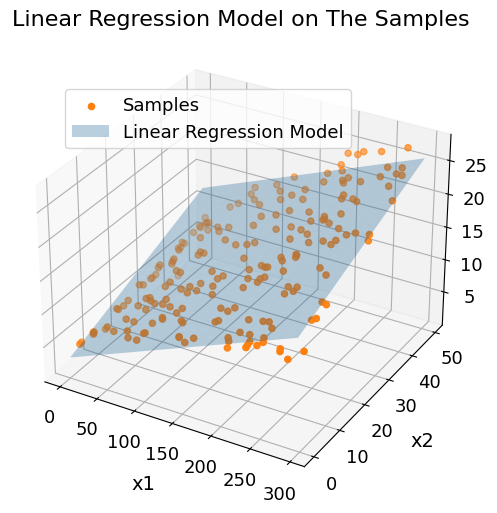

In [24]:
#To visualize the trained linear regression model, call modelplot function, input: beta,X,y,x1range,x2range
modelplot(beta,X)

# **K-nearest Neighbor regression model**

Besides parametric models such as linear regression, we also have non-parametric methods that do not assume the relationship between data. The simplest non-parametric model is the K-nearest Neighbor (KNN) model, which creates a predictive model by taking the average value of the nearest neighbours at any point. 

You can use the same data set to create a KNN by first executing the cell below to initialize KNN plotting and prediction. For now, we will use an existing KNN package from Scikit-learn (although coding KNN is very easy!). Because KNN is based on distance, it is essential to normalize the scale of all the input variables to 0-1 first. The detail is handled by the code below; all you need to do for now is to experiment with KNN regression and see the effect of the number of neighbours (i.e., ```n_neighbors```).


In [25]:
#@title Initialize KNN plotting and prediction
from sklearn import neighbors
from sklearn import preprocessing

#Function to visualize the trained linear regression model. This procedure can only be conducted if the number of variables are 1/2
def modelplotKNN(knn,X,y):
    n_var = X.shape[1]
    if n_var == 2: #Procedure for two variables
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])]) 
        x2range = np.array([np.min(X[:,1]), np.max(X[:,1])])
        #Create prediction locations
        x1, x2= np.meshgrid(np.linspace(x1range[0],x1range[1],21),np.linspace(x2range[0],x2range[1],21)) 

        x1n, x2n = np.meshgrid(np.linspace(0,1,21),np.linspace(0,1,21)) 
        x1_vec = x1n.reshape(-1,); x2_vec = x2n.reshape(-1,)
        X_temp = np.ones((21*21,2)); X_temp[:,0] = x1_vec; X_temp[:,1] = x2_vec
        #Calculates predictions at the prediction locations
        y_hat_vec = knn.predict(X_temp)
        y_hat_mat = y_hat_vec.reshape(21,21) #Transform the vector of predictions into matrix
        
        fig = plt.figure(figsize=[8,6])
        #ax = fig.gca(projection='3d')
        ax = fig.add_subplot(projection='3d')
        ax.scatter3D(X[:,0],X[:,1],y,color='tab:orange',label='Samples')
        surf = ax.plot_surface(x1,x2,y_hat_mat,alpha=0.3,color='tab:blue',label='KNN Model')
        surf._facecolors2d=surf._facecolor3d
        surf._edgecolors2d=surf._edgecolor3d
        ax.set_xlabel('x1',fontsize=14)
        ax.xaxis.labelpad = 10
        ax.set_ylabel('x2',fontsize=14)
        ax.yaxis.labelpad = 10
        ax.set_zlabel('y',fontsize=14)
        plt.title('KNN Model on The Samples',fontsize=16)
        ax.legend(loc=2,bbox_to_anchor=(0.1, 0.9))
        plt.show()
    
    elif n_var == 1: #Procedure for one variable
        #Create prediction locations
        x1range = np.array([np.min(X[:,0]), np.max(X[:,0])])
        x1 = np.linspace(x1range[0],x1range[1],21)
        x1n = np.linspace(0,1,21)
        X_temp = np.ones((21,1)); X_temp[:,0] = x1n
        #Calculates predictions at the prediction locations
        y_hat = knn.predict(X_temp)
        
        fig = plt.figure(figsize=[8,6])
        plt.scatter(X,y,color='tab:orange', label='Samples')
        plt.plot(x1,y_hat,color='tab:blue',linewidth=4, label='KNN Model')
        plt.title('KNN Model on The Samples', fontsize=16)
        plt.xlabel('x',fontsize=14)
        plt.ylabel('y',fontsize=14)
        plt.legend()
        plt.grid()
        plt.show()
    else:
        print("Your data has more than two variables")

Now you can create the KNN model for the data set that we used earlier, just change ```n_neighbors``` and see the effect on your prediction (note that the visualization only applies for $p=1$ or $p=2$):

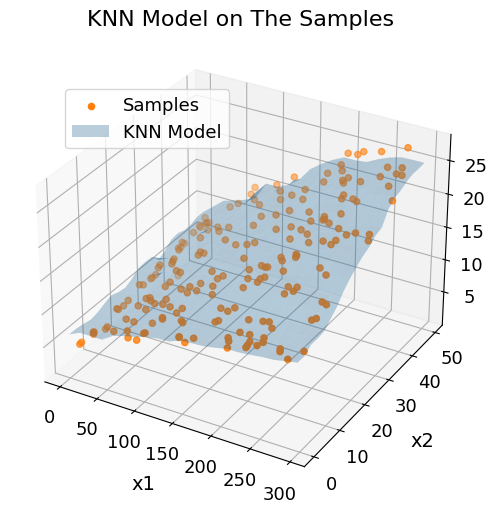

In [26]:
#@title Visualize the trained KNN model

n_neighbors = 10 # Number of neighbors

min_max_scaler = preprocessing.MinMaxScaler()
X_norm = min_max_scaler.fit_transform(X)
knn = neighbors.KNeighborsRegressor(n_neighbors)
knn.fit(X_norm, y)

modelplotKNN(knn,X,y)


You can also predict the $y$ value everywhere! Let's try that by giving an arbitrary value of $x$:

In [27]:
x = np.array([[200,20]])
knn.predict(min_max_scaler.transform(x))

array([[15.95]])

Similar to linear regression, you can also use your excel file to make predictions based on the data written in excel / notepad:

In [28]:
#Read the .csv file using Panda's module
data_pred_knn = pd.read_csv('data/prediction_sites_Advertising_2D.csv')
#Convert the format of the data into numy array. This procedure is conducted to make it consistent with other variables afterward. This formatted data will be saved as data_array.
X_pred = data_pred_knn.to_numpy()
ypredKNN = knn.predict(min_max_scaler.transform(X_pred))
print(ypredKNN)

[[15.95]
 [12.11]
 [15.64]
 [15.57]]


Similar to the linear regression, you can also save the predicted values from KNN into a csv file (which you can download into your PC):

In [29]:
filenamecsv = 'data/predicted_KNN_values_Advertising_2D.csv' # Name of the file
filenamexls = 'data/predicted_KNN_values_Advertising_2D.xlsx' # Name of the file
DF = pd.DataFrame(np.hstack([X_pred,ypredKNN])) # Create a dataframe
DF.to_csv(filenamecsv) # Save the predicted data to csv
DF.to_excel(filenamexls) # Save the predicted data to csv

# **That's all folks!**